You can download this post as a Juypter notebook [here](/posts/more-march-madness-monte-carlo-style.ipynb)

# MMMC the 2021 update

See the [original blog post](http://www.mglerner.com/blog/?p=16) for details and history. And the [2015 update](https://mglerner.github.io/posts/more-march-madness-monte-carlo-style.html) for ... the 2015 update. For this update (2021), I mainly just updated the code to deal with Python 3. We also paid for a [kenpom](http://kenpom.com) subscription and used some of his data like "average team height" to answer some great student questions.

Here's the short story: in my Statistical and Thermal Physics class, we want to use Monte Carlo simulations to generate brackets for March Madness. There are at least two obvious ways to go about this:

 1. Make some function that tells us the chance that team A beats team B, then flip coins for each matchup. That gets you one bracket. Repeat 100,000 times, collect statistics. This is the way Nate Silver's 538.com handles simulations for [basketball](https://projects.fivethirtyeight.com/2020-march-madness-predictions/), [elections](https://projects.fivethirtyeight.com/2020-election-forecast/), etc, and I should probably implement it (note to self/motivated students: it's as easy as just generating 100,000 new brackets at a given temperature).
 
 2. Generate one bracket, then do a Monte-Carlo walk through bracket space. This is tougher. We have to figure out how to make a move in bracket space, which is part of the fun of Monte Carlo simulations in general. To see how this is done, check out the code in `Bracket.swap` and `Brackets.simulate`.
 
As you can tell, we take option 2 above. Here's a walkthrough. First, load up our standard IPython setup

<!-- TEASER_END -->

In [36]:
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

## The basics

make me a single bracket at a given temperature

In [37]:
import MarchMadnessMonteCarlo as MMMC
teams = MMMC.regional_teams['south']
b = MMMC.Bracket(teams=teams,T=0.5)
print (b)

Baylor (1)                                                   
Hartford (16)             Har (16)                           
North Carolina (8)                                           
Wisconsin (9)             Nor (8)  Nor (8)                   
Villanova (5)                                                
Winthrop (12)             Vil (5)                            
Purdue (4)                                                   
North Texas (13)          Pur (4)  Pur (4)  Nor (8)          
Texas Tech (6)            Uta (11) Uta (11) Uta (11) Uta (11)
Utah St. (11)                                                
Arkansas (3)              Ark (3)                            
Colgate (14)                                                 
Florida (7)               Vir (10) Vir (10)                  
Virginia Tech (10)                                           
Ohio St. (2)              Ohi (2)                            
Oral Roberts (15)                                            
Total br

Now, instead of asking for all of the teams in the South, make up a set of Final Four teams, and run 1000 simulations. Show some statistics

Lowest energy bracket
Gonzaga (1)                                
Michigan (1)              Gon (1)          
Baylor (1)                Bay (1)  Gon (1) 
Illinois (1)                               
Total bracket energy: -3.114957196856172

Most common bracket (152)
Gonzaga (1)                                
Michigan (1)              Gon (1)          
Baylor (1)                Ill (1)  Gon (1) 
Illinois (1)                               
Total bracket energy: -3.0809034780450464



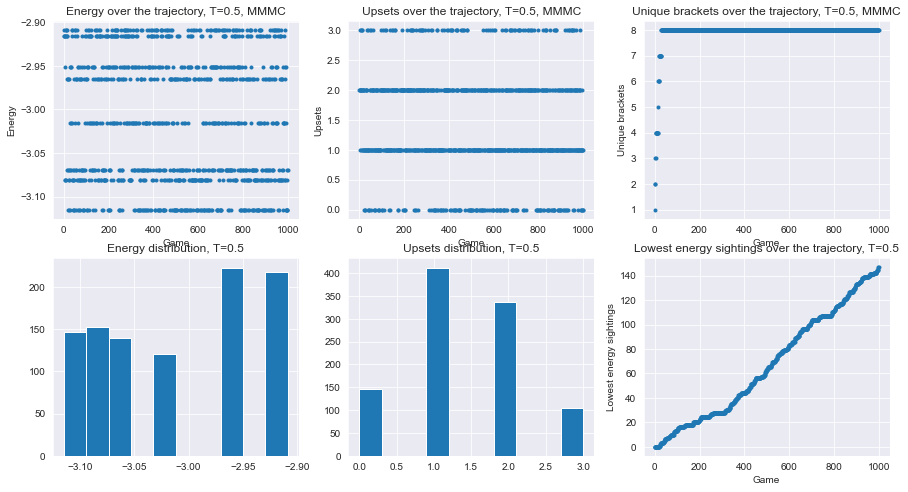

In [38]:
sr = MMMC.simulate(1000,['Gonzaga','Michigan','Baylor','Illinois'],0.5)
MMMC.showstats(sr,newfig=True)

As you can see, we fully sample bracket space pretty quickly (look at the graph in the top right, with the unique brackets shown).

# What should our temperature be?

If we had chosen option 1 at the top, we'd just flip coins with a given probability of winning. Here (and this may be a questionable decision), we need to set an overall temperature for our simulation. Intuitively, the higher the temperature, the closer we come to a random outcome. The lower the temperature, the closer we come to a "best seed always wins" bracket. If we're going to make sense of temperature, we should pick a reasonable energy function.

We used to use [KenPom](http://www.kenpom.com)'s `log5` defined as

```python
def log5_energy_game(winner, loser):
    A,B = strength[winner],strength[loser]
    # see http://207.56.97.150/articles/playoff2002.htm
    win_pct = (A-A*B)/(A+B-2*A*B)
    return -win_pct
```

Conveniently, that's coded up for you in MarchMadnessMonteCarlo.examples. Now we use other energy functions, mainly student-defined ones.

In [39]:
import MarchMadnessMonteCarlo.examples
MMMC.set_energy_function(MarchMadnessMonteCarlo.examples.default_energy_game)

Now, what should our actual temperature be? Historically, we know that an 8 seed vs. a 9 seed should essentially be a tossup. So, as a proxy here, we could just look at the chance of an 8 seed winning over a range of temperatures, and pick the point where it's pretty close to 0.5.

In [52]:
def winpct8(team8,team9,T,numtrials=10000):
    results = [MMMC.playgame(team8,team9,T)[0] == team8 for i in range(numtrials)]
    return np.average(results)
def plotwins(team8,team9,numtrials=5000,ax=None,maxT=3):
    if ax is None:
        fig, ax = plt.subplots()
    Ts = np.linspace(0.001,maxT,100)
    pct = [winpct8(team8,team9,T,numtrials) for T in Ts]
    ax.plot(Ts,pct,label='{t1} vs. {t2}'.format(t1=team8,t2=team9))
    ax.set_xlabel('T')
    ax.set_ylabel('winpct')

So Ollie thinks temperature should be 12.5

Kiet thinks it should be 5 and I need to send him brackets for 5 and 10

Olivia thinks temperature shoudl be 0.35

Cbarlie thinks temperature should be 0.75

In [41]:
import MarchMadnessMonteCarlo.student2021
import MarchMadnessMonteCarlo.RankingsAndStrength

# Using our "default" energy function

Here, we played around with several different versions in class, and ended up looking more specifically at KenPom's `AdjEm`. Note that this is _not_ what Ken Pomeroy actually does. He uses a combination of that and average time played. I basically do his thing in my energy function lower down, though of course I sample from a Boltzmann distribution.

```python
def default_energy_game(winner, loser):
    """This is where you'll input your own energy functions. Here are
    some of the things we talked about in class. Remember that you
    want the energy of an "expected" outcome to be lower than that of
    an upset.

    """
    result = -(strength[winner] - strength[loser])
    result = regional_rankings[winner] - regional_rankings[loser]
    result = regional_rankings[winner]/regional_rankings[loser]
    result = -(strength[winner]/strength[loser])
    result = -(strength[winner]-strength[loser])/50.0
    #result = random()
    #result = color of team 1 jersey better than color of team 2 jersey
    #print "energy_game(",winner,loser,")",result
    return result
```

We'll look at it for all four of the 8 vs. 9 matchups

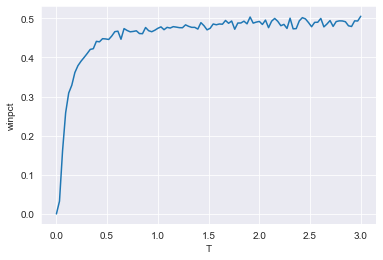

In [42]:
plotwins('North Carolina',"Wisconsin")

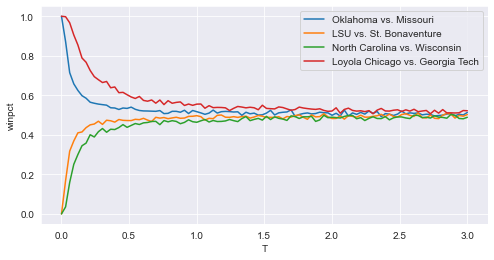

In [43]:
fig, ax = plt.subplots(figsize=(8,4))
plotwins('Oklahoma','Missouri',ax=ax)
plotwins('LSU','St. Bonaventure',ax=ax)
plotwins('North Carolina',"Wisconsin",ax=ax)
plotwins('Loyola Chicago','Georgia Tech',ax=ax)
plt.legend()

A couple of things jump out. First, the red and blue lines make sense: at very low temperatures, the higher-ranked team wins all the time. As temperature increases, unlikely outcomes become more likely.

The red and orange lines come from data in the real world: KenPom has the number 9 team ranked abouve the number 8 team. So the curve approaches 50% from below instead of from above.

Second, just eyeballing that, it looks like we could make a legitimate argument for almost anything between T=1 and 2. If you were looking at previous years, we're using a different energy function, so these numbers are a bit different this year.

What does that do to "clear" matchups? Well, Gonzaga is a big favorite over Villinova with this model:

In [44]:
MarchMadnessMonteCarlo.examples.default_energy_game('Gonzaga','Kansas')

-0.3117999999999999

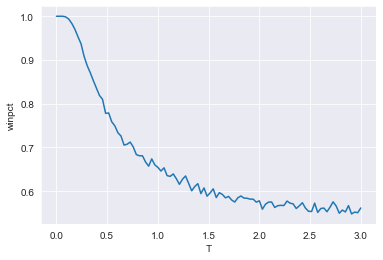

In [45]:
plotwins('Gonzaga','Kansas')

If I pick `T=1.0`, I get Gonzaga, the favorite, winning 55% of the time. You can feel free to choose a "more reasonable" temperature, but I'm rooting for KU here!

# Looking at Olivia's energy function

Olivia thinks that the real key is just how tall the team is, on average.

```python
def olivia_energy_game(winner,loser):
    wv = -np.log(height[winner])
    lv = -np.log(height[loser])
    return wv - lv
```

In [46]:
import MarchMadnessMonteCarlo.student2021

In [50]:
MMMC.set_energy_function(MarchMadnessMonteCarlo.student2021.olivia_energy_game)

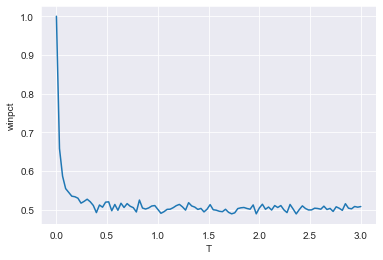

In [51]:
plotwins('North Carolina',"Wisconsin")

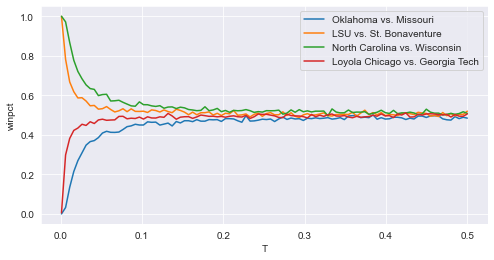

In [55]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 0.5
plotwins('Oklahoma','Missouri',ax=ax,maxT=maxT)
plotwins('LSU','St. Bonaventure',ax=ax,maxT=maxT)
plotwins('North Carolina',"Wisconsin",ax=ax,maxT=maxT)
plotwins('Loyola Chicago','Georgia Tech',ax=ax,maxT=maxT)
plt.legend()

And so Olivia thought that 0.35 was a reasonable temperature. Let's look at some statistics. This uses `runbrackets2` which runs each region independently, then runs final fours, etc.

In [61]:
T = 0.35

In [63]:
import MarchMadnessMonteCarlo.Brackets
imp.reload(MarchMadnessMonteCarlo.Brackets)
imp.reload(MMMC)

<module 'MarchMadnessMonteCarlo' from '/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/__init__.py'>

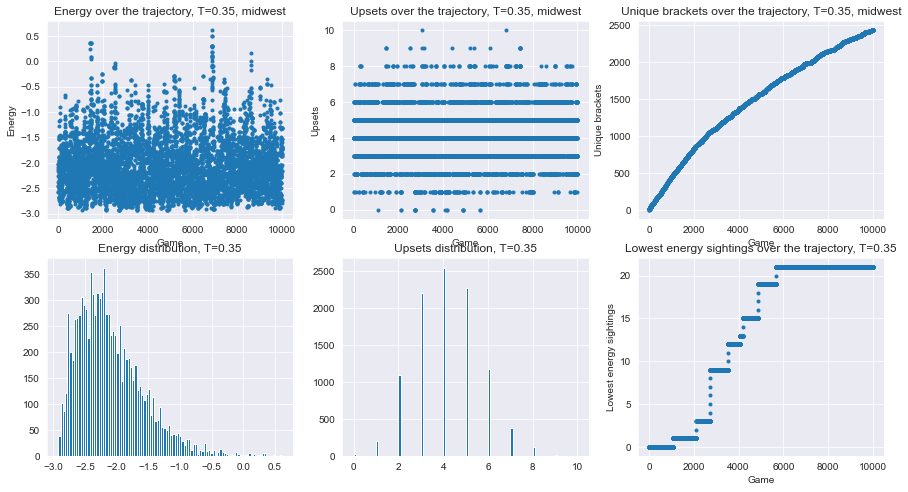

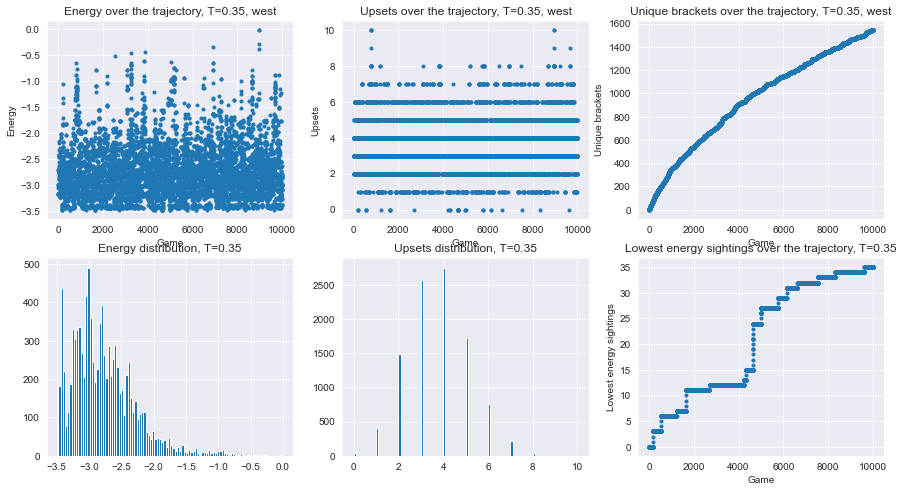

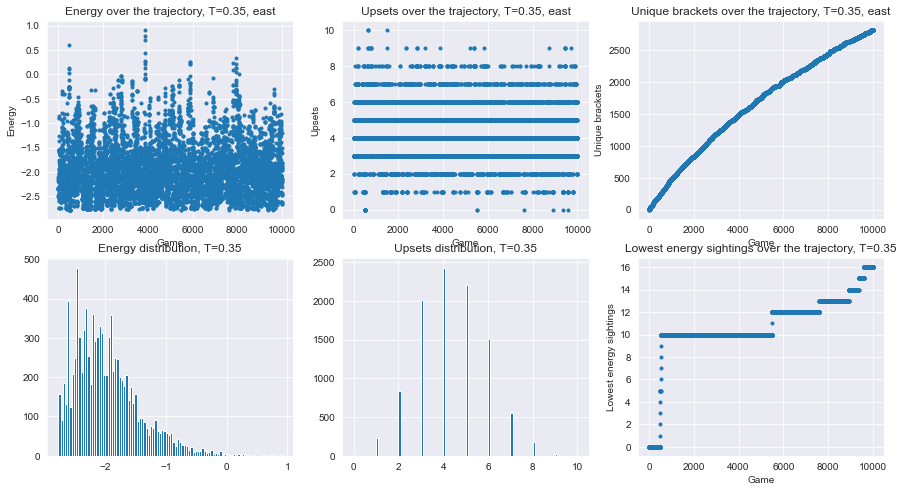

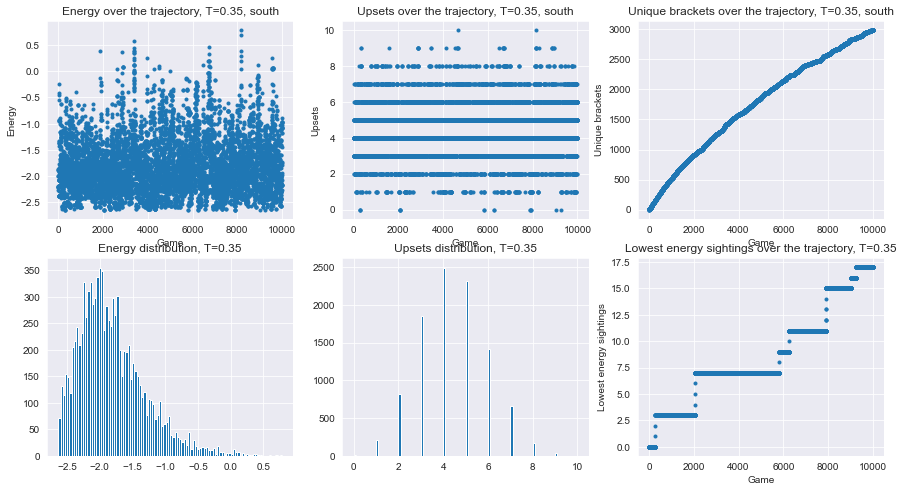

In [64]:
# Basic visualization
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=T,silent=True)
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

Our take on that was that it looked like a low-temperature sim, but looked like a Boltzmann distribution. Cool!

Now let's pick brackets for the pool.

In [66]:
results = MMMC.runbracket1(ntrials=10000,T=T)

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Loy (8)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ten (5)                                              
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Ten (5)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             San (6)                                              
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  San (6)                                     
Clemson (7)       

# Kiet

Kiet has a combination of NCAA ranking, offensive and defensive efficiencies, and luck.

```python
def kiet_energy_game(winner,loser):
    return (rank[winner]/rank[loser])*((adjo[winner] + adjd[winner] + luck[winner]) / (adjo[loser] + adjd[loser] + luck[loser]))
```

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


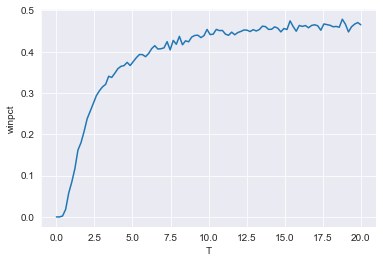

In [69]:
MMMC.set_energy_function(MarchMadnessMonteCarlo.student2021.kiet_energy_game)
plotwins('North Carolina',"Wisconsin",maxT=20)

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


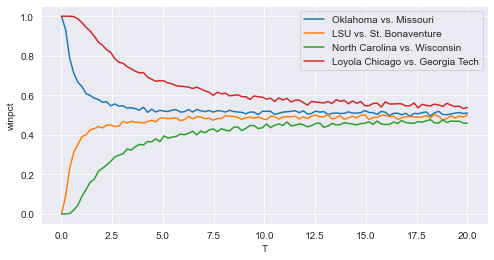

In [71]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 20
plotwins('Oklahoma','Missouri',ax=ax,maxT=maxT)
plotwins('LSU','St. Bonaventure',ax=ax,maxT=maxT)
plotwins('North Carolina',"Wisconsin",ax=ax,maxT=maxT)
plotwins('Loyola Chicago','Georgia Tech',ax=ax,maxT=maxT)
plt.legend()

So Kiet thinks it should be 5

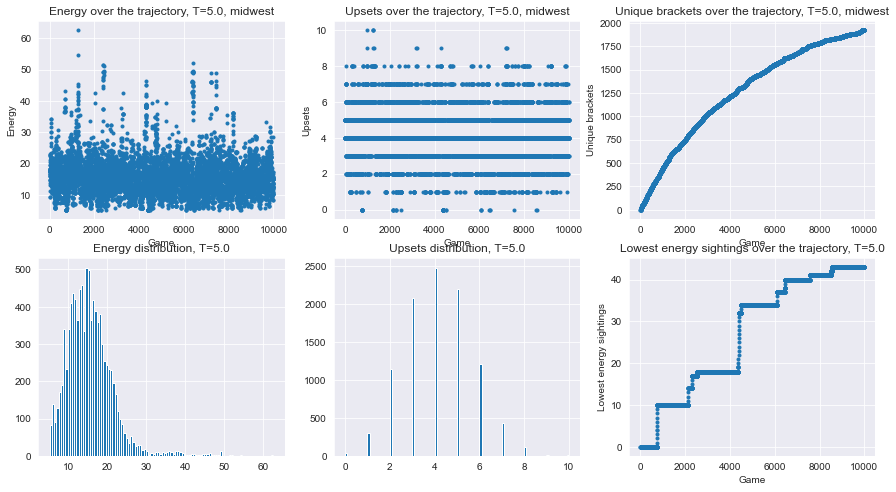

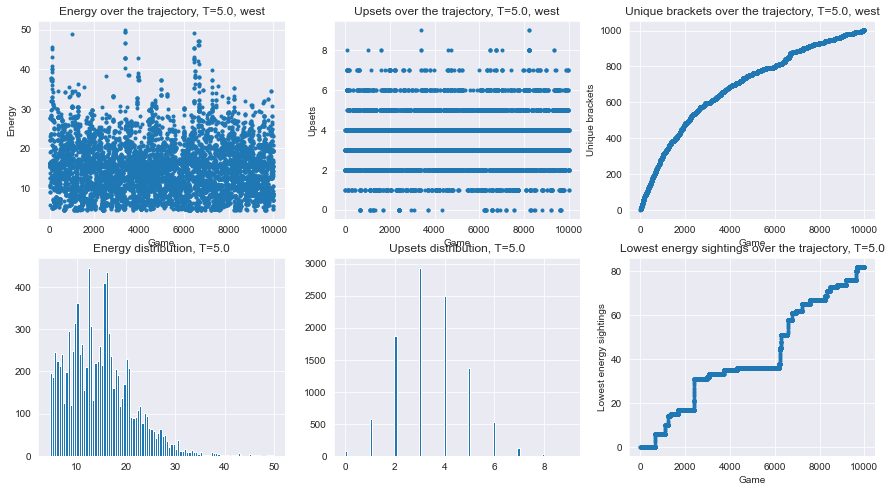

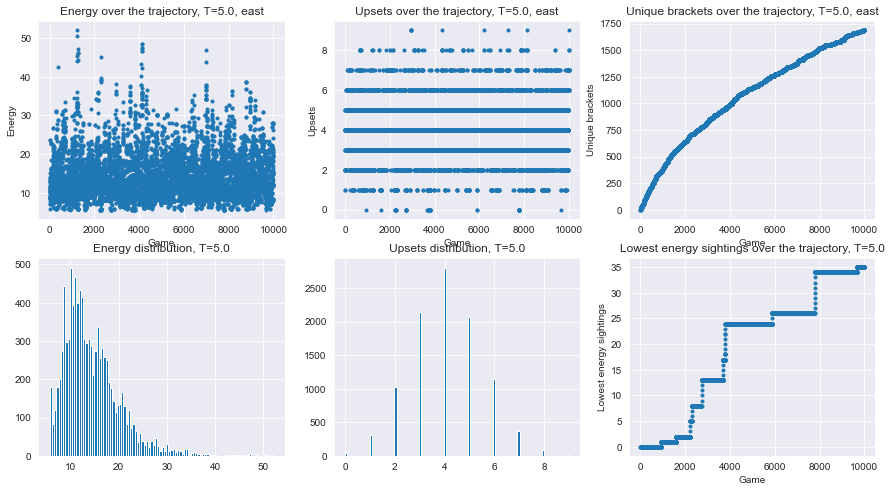

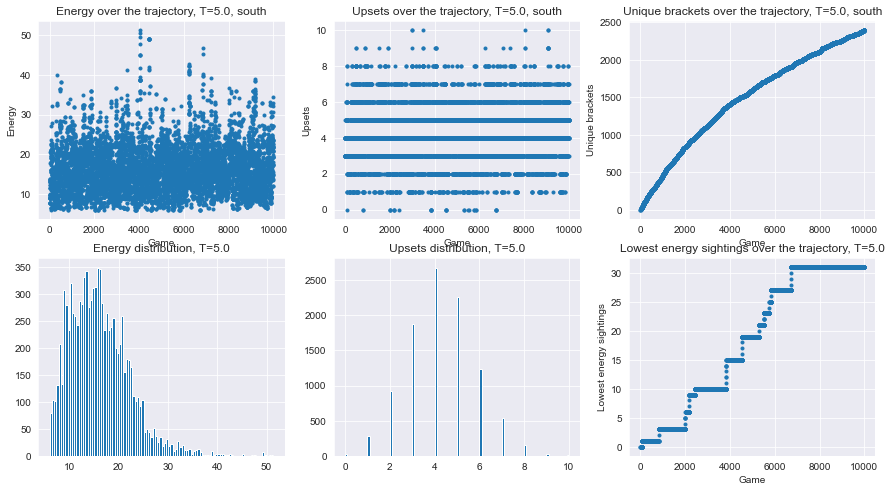

In [73]:
T = 5.0
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=T,silent=True)
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

In [75]:
results = MMMC.runbracket1(ntrials=10000,T=T)

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Loy (8)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ten (5)                                              
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Ten (5)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             San (6)                                              
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  San (6)                                     
Clemson (7)       

# Ollie

Ollie looks at the strength of schedule for the teams.

```python
def ollie_energy_game(winner,loser):
    sos_w, sos_l = sos[winner],sos[loser]
    return sos_w/sos_l
```

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


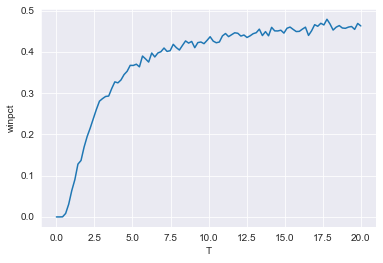

In [77]:
MMMC.set_energy_function(MarchMadnessMonteCarlo.student2021.ollie_energy_game)
plotwins('North Carolina',"Wisconsin",maxT=20)

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


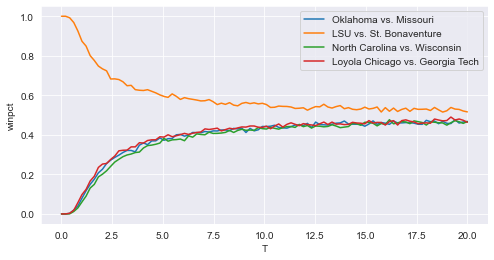

In [78]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 20
plotwins('Oklahoma','Missouri',ax=ax,maxT=maxT)
plotwins('LSU','St. Bonaventure',ax=ax,maxT=maxT)
plotwins('North Carolina',"Wisconsin",ax=ax,maxT=maxT)
plotwins('Loyola Chicago','Georgia Tech',ax=ax,maxT=maxT)
plt.legend()

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Visualization.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot2)


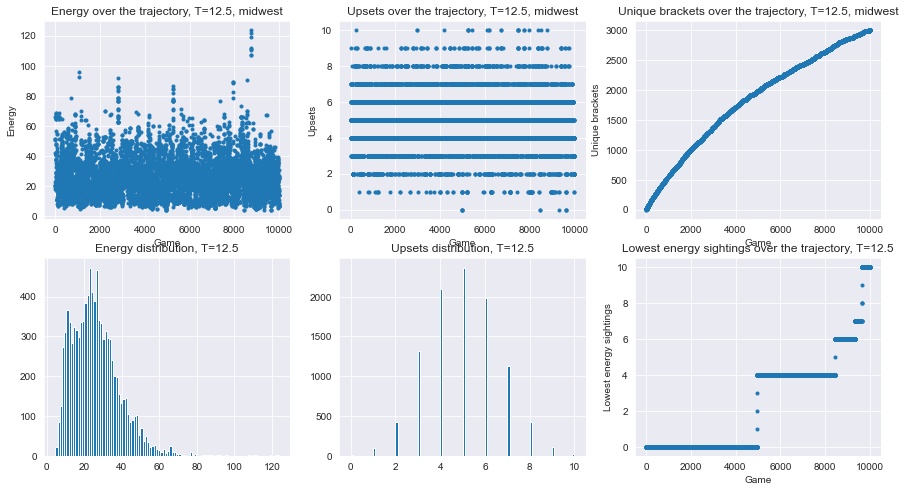

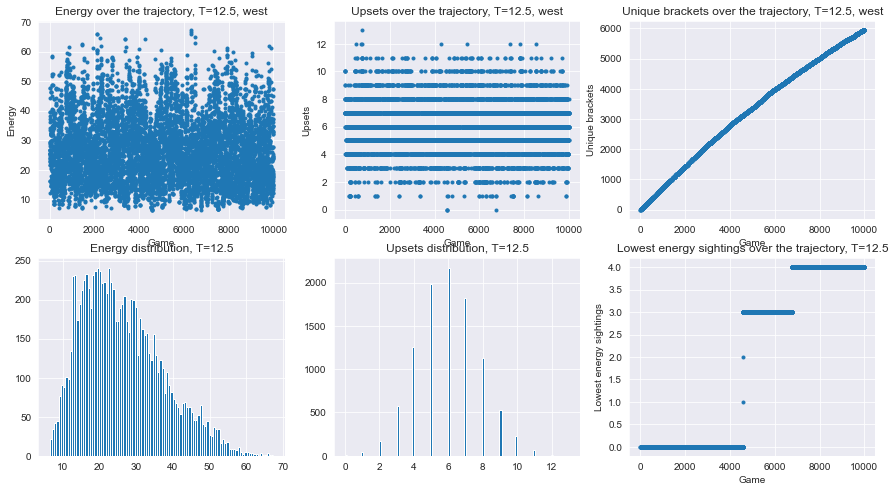

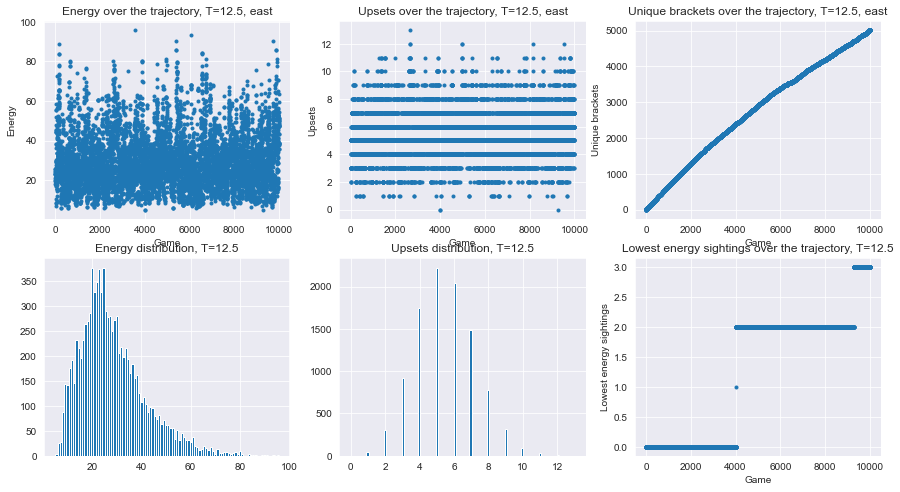

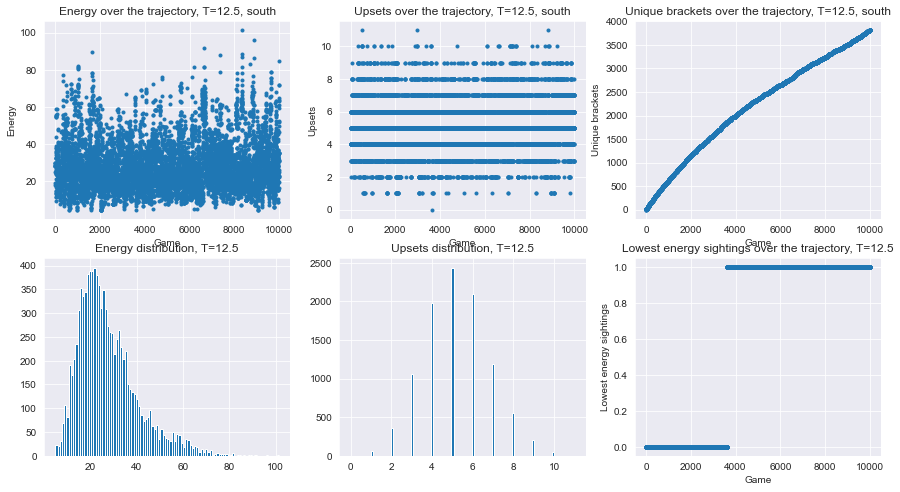

In [79]:
T = 12.5
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=T,silent=True)
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

In [80]:
results = MMMC.runbracket1(ntrials=10000,T=T)

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Geo (9)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ten (5)                                              
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Okl (4)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             Syr (11)                                             
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  Wes (3)                                     
Clemson (7)       

# Charlie

Charlie uses the adjusted offensive efficiencies from Ken Pomeroy's proprietary data.

```python
def charlie_energy_game(winner,loser):
    winner_off_eff = offeff[winner]
    loser_off_eff = offeff[loser]
    return -winner_off_eff/loser_off_eff
```

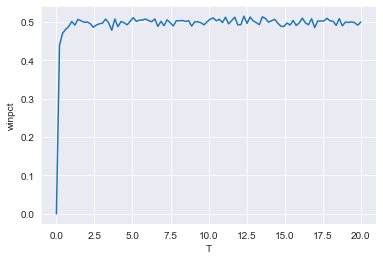

In [81]:
MMMC.set_energy_function(MarchMadnessMonteCarlo.student2021.charlie_energy_game)
plotwins('North Carolina',"Wisconsin",maxT=20)

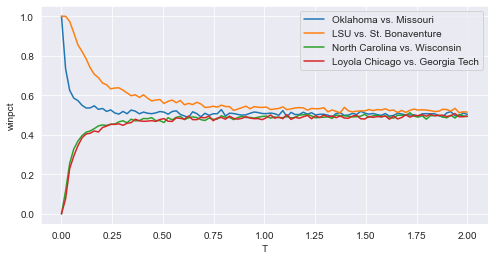

In [82]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 2
plotwins('Oklahoma','Missouri',ax=ax,maxT=maxT)
plotwins('LSU','St. Bonaventure',ax=ax,maxT=maxT)
plotwins('North Carolina',"Wisconsin",ax=ax,maxT=maxT)
plotwins('Loyola Chicago','Georgia Tech',ax=ax,maxT=maxT)
plt.legend()

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Visualization.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot2)


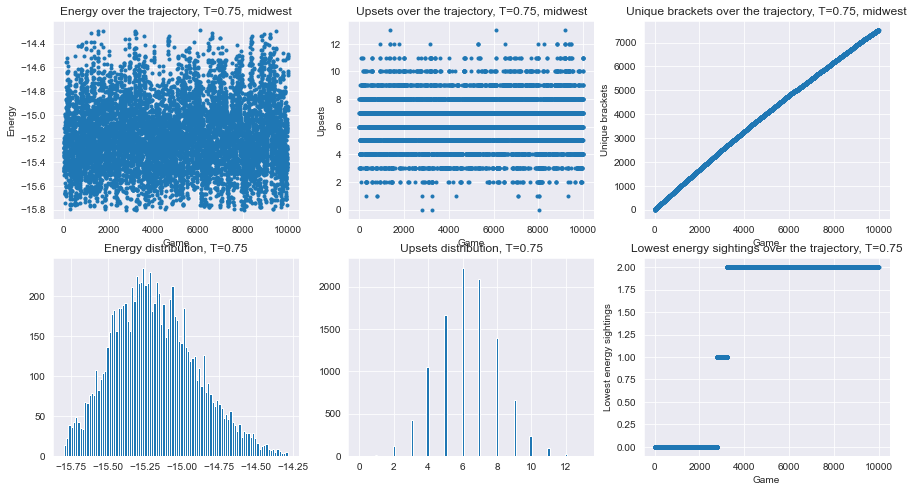

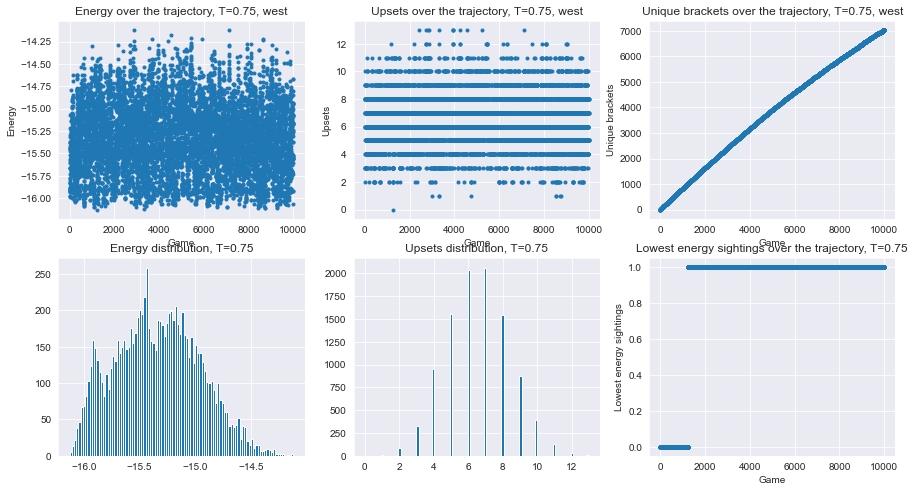

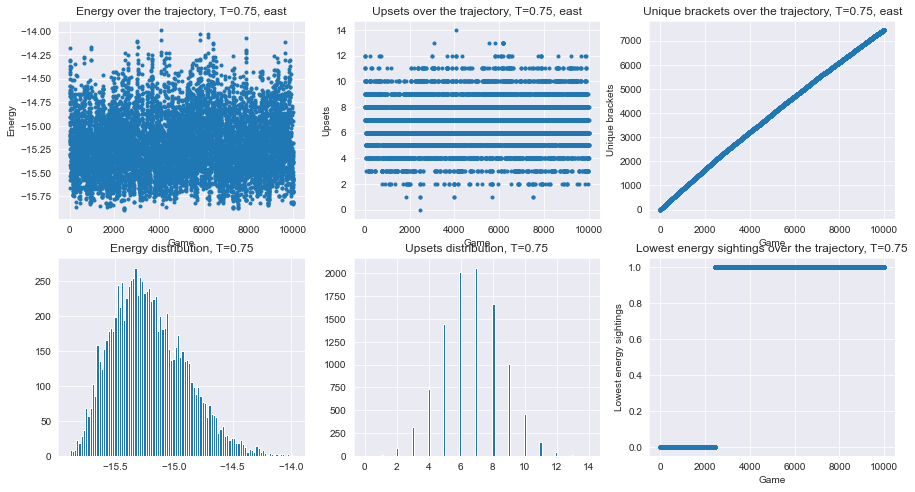

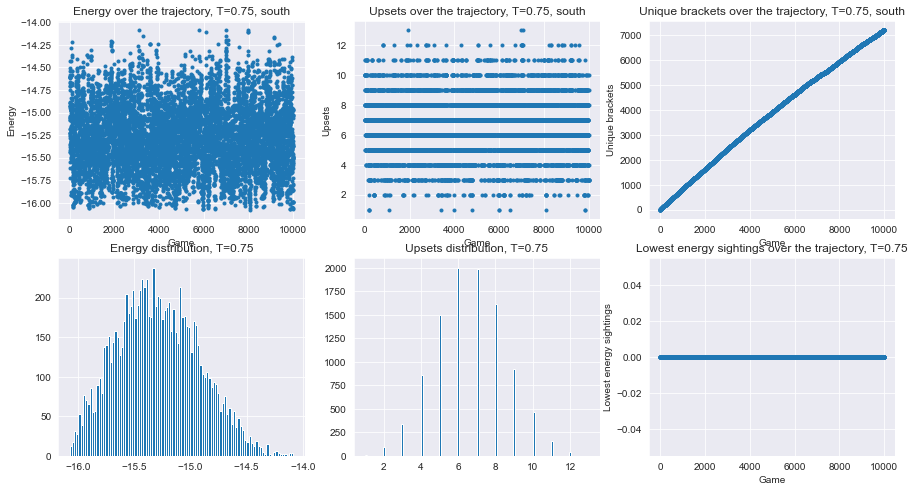

In [83]:
T = 0.75
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=T,silent=True)
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

In [84]:
results = MMMC.runbracket1(ntrials=10000,T=T)

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Geo (9)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ore (12)                                             
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Okl (4)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             Syr (11)                                             
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  Wes (3)                                     
Clemson (7)       

# OK, so what does Michael think this year?

I definitely understood the old `log5` stuff, but it's been a while. I saw [this reddit post](https://www.reddit.com/r/CollegeBasketball/comments/5xir8t/calculating_win_probability_and_margin_of_victory/) and I tihk it makes sense.

```python
#import scipy as sp
def mgl_energy_game(winner,loser):
    pointdiff = (adjem[winner] - adjem[loser])*(adjt[winner]+adjt[loser])/200
    # No adjustment for home court advantage. Those efficiencies are per 100 possessions, so we divide by 200.
    # Now assume games are normally distributed, and rumor has it you want sigma = 11 for that
    #sigma = 11
    #prob = 0.5*(1 + sp.special.erf(pointdiff - sigma)/(sigma*np.sqrt(2))
    # but we don't want a normally distributed thing. we want a boltzmann distributed thing.
    # so we'll just use the expected point diff.
    return -pointdiff
```

This should give similar results to KenPom, except that I sample from a Boltzmann distribution instead of a normal distribution. Oh, also I end up specifically picking brackets where KU wins, because I'm a total homer.

In [91]:
imp.reload(MMMC.student2021)
MMMC.student2021.michael_energy_game('North Carolina','Wisconsin')

1.7497599999999989

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


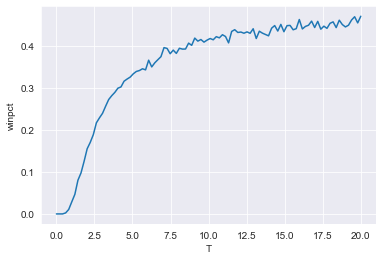

In [92]:
MMMC.set_energy_function(MarchMadnessMonteCarlo.student2021.michael_energy_game)
plotwins('North Carolina',"Wisconsin",maxT=20)

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


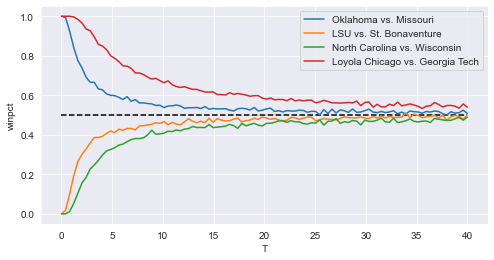

In [98]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 40
plotwins('Oklahoma','Missouri',ax=ax,maxT=maxT)
plotwins('LSU','St. Bonaventure',ax=ax,maxT=maxT)
plotwins('North Carolina',"Wisconsin",ax=ax,maxT=maxT)
plotwins('Loyola Chicago','Georgia Tech',ax=ax,maxT=maxT)
plt.hlines(0.5,0,maxT,linestyle='dashed',color='black')
plt.legend()

And what does a 1 vs 16 look like?

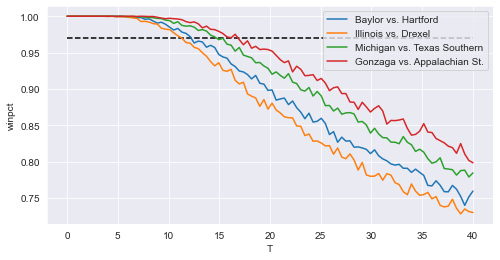

In [100]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 40
plotwins('Baylor','Hartford',ax=ax,maxT=maxT)
plotwins('Illinois','Drexel',ax=ax,maxT=maxT)
plotwins('Michigan',"Texas Southern",ax=ax,maxT=maxT)
plotwins('Gonzaga','Appalachian St.',ax=ax,maxT=maxT)
plt.hlines(0.97,0,maxT,linestyle='dashed',color='black')
plt.legend()

And a 4 vs 13?

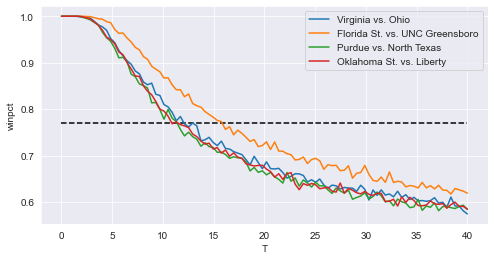

In [101]:
fig, ax = plt.subplots(figsize=(8,4))
maxT = 40
plotwins('Virginia','Ohio',ax=ax,maxT=maxT)
plotwins('Florida St.','UNC Greensboro',ax=ax,maxT=maxT)
plotwins('Purdue',"North Texas",ax=ax,maxT=maxT)
plotwins('Oklahoma St.','Liberty',ax=ax,maxT=maxT)
plt.hlines(0.77,0,maxT,linestyle='dashed',color='black')
plt.legend()

So let's make it 13.

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)
/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Visualization.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot2)


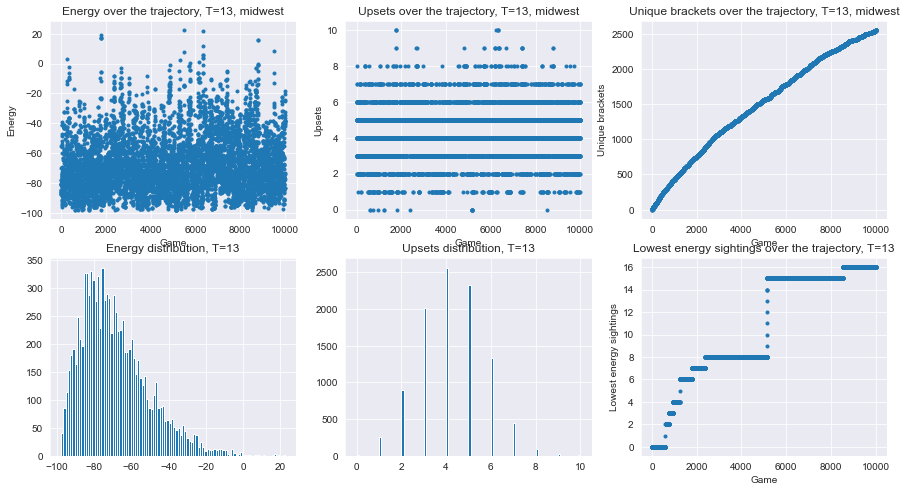

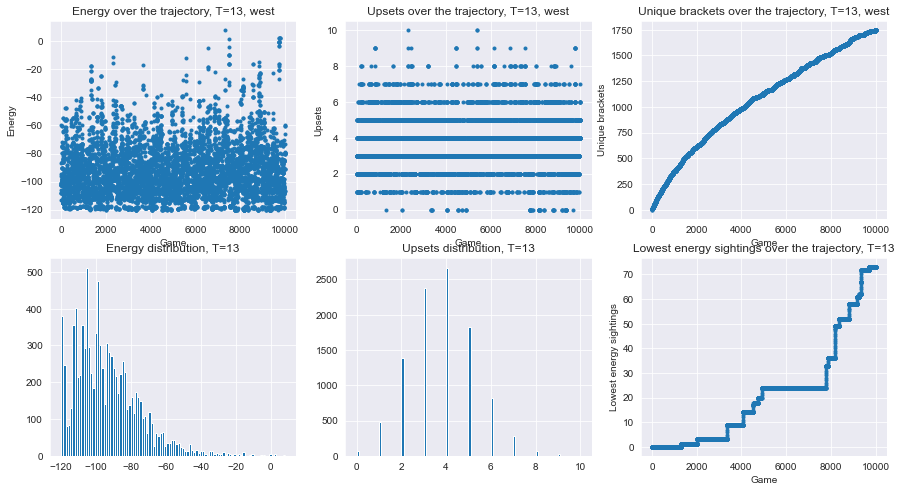

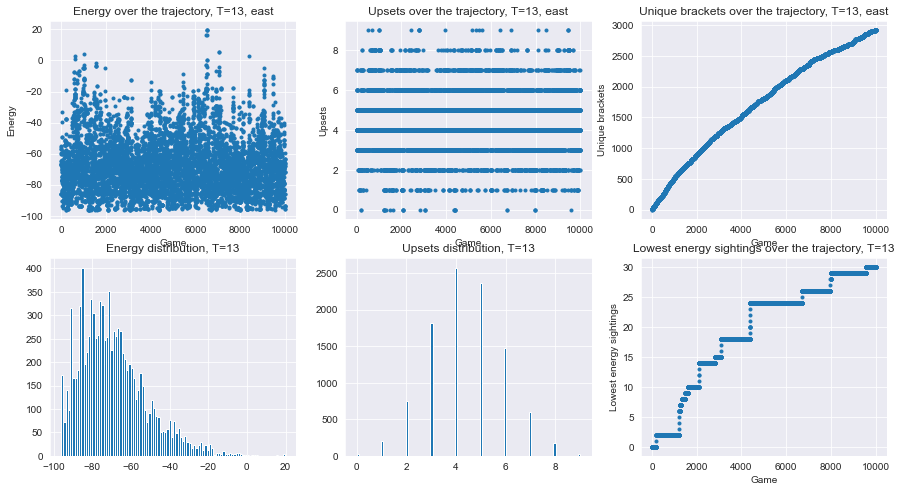

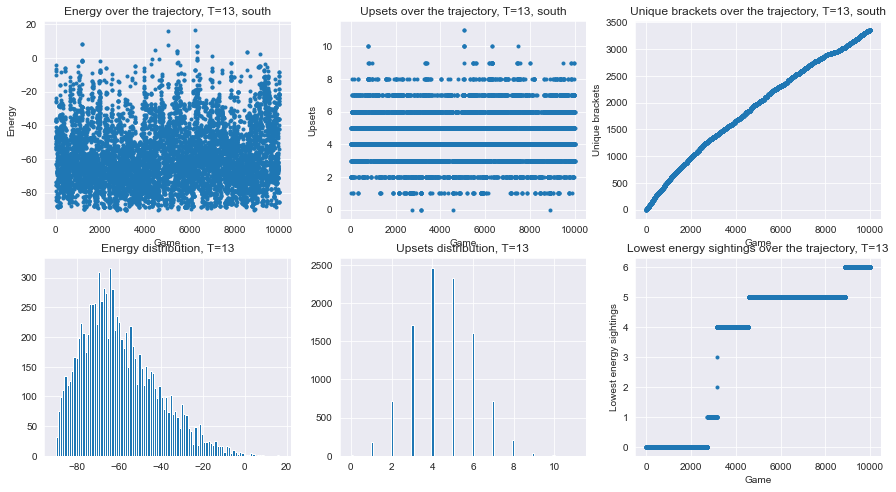

In [102]:
T = 13
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=T,silent=True)
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

In [103]:
results = MMMC.runbracket1(ntrials=10000,T=T)

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Loy (8)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ten (5)                                              
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Ten (5)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             San (6)                                              
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  San (6)                                     
Clemson (7)       

## And now for the "Michael Loves Kansas" option

The above is great, but what if I want to restrict to games where only Kansas wins the bracket? Sadly, that means I need to run a *lot* more brackets before I get even a few hundred, but such is the life of a homer.

In [104]:
# Run a buuuuuunch of sims since I'm only going to be picking a tiny fraction of them.
results = MMMC.runbracket1(ntrials=1000000,T=T) # yeah, this takes a while to run.

Lowest energy bracket
Illinois (1)                                                                   
Drexel (16)               Ill (1)                                              
Loyola Chicago (8)                                                             
Georgia Tech (9)          Loy (8)  Ill (1)                                     
Tennessee (5)                                                                  
Oregon St. (12)           Ten (5)                                              
Oklahoma St. (4)                                                               
Liberty (13)              Okl (4)  Ten (5)  Ill (1)                            
San Diego St. (6)                                                              
Syracuse (11)             San (6)                                              
West Virginia (3)                                                              
Morehead St. (14)         Wes (3)  San (6)                                     
Clemson (7)       

In [105]:
goodbrackets = [i for i in results['all'].brackets if i.bracket[-1][0] == 'Kansas']
from MarchMadnessMonteCarlo.Brackets import Stats
lb, mcb, mcb_count, unique_brackets, lowest_sightings = Stats.gather_uniquestats(goodbrackets)
sr = MMMC.SimulationResults(goodbrackets,unique_brackets,lb,lowest_sightings,mcb,mcb_count)
trueresults = {'all':sr}
h = HTML(MMMC.maketable(trueresults))
h

Team,Region,Rank,2nd Round,3rd Round,Sweet 16,Elite 8,Final 4,Championship,Win
Kansas,west,3,100.0,100.0,100.0,100.0,100.0,100.0,100.0
Baylor,south,1,100.0,90.73170731707317,69.02439024390245,56.58536585365854,40.73170731707317,26.097560975609756,0.0
Illinois,midwest,1,100.0,92.6829268292683,80.0,71.21951219512195,42.926829268292686,25.365853658536587,0.0
Houston,midwest,2,100.0,91.21951219512195,72.92682926829268,57.80487804878049,34.146341463414636,16.585365853658537,0.0
Ohio St.,south,2,100.0,85.1219512195122,61.46341463414634,42.68292682926829,20.48780487804878,6.829268292682927,0.0
Purdue,south,4,100.0,62.68292682926829,35.1219512195122,12.195121951219512,7.317073170731708,4.146341463414634,0.0
West Virginia,midwest,3,100.0,72.1951219512195,37.80487804878049,13.658536585365853,5.853658536585366,3.1707317073170733,0.0
Wisconsin,south,9,100.0,52.4390243902439,17.317073170731707,6.829268292682927,4.878048780487805,2.926829268292683,0.0
Texas Tech,south,6,100.0,64.14634146341463,37.5609756097561,17.5609756097561,5.853658536585366,2.682926829268293,0.0
Villanova,south,5,100.0,66.34146341463415,39.26829268292683,15.609756097560975,6.585365853658536,2.4390243902439024,0.0


In [112]:
len(goodbrackets)

410

In [110]:
# do not ask about `sr.lowest_bracket` ... it's hand-calculated at low T.
# sr.lowest_bracket_count

What about a friend of mine who wanted MSU to win? Not looking good, friend ...

In [113]:
msubrackets = [i for i in results['all'].brackets if i.bracket[-1][0] == 'Michigan St']
msulb, msumcb, msumcb_count, msuunique_brackets, msulowest_sightings = Stats.gather_uniquestats(msubrackets)
msusr = MMMC.SimulationResults(msubrackets,msuunique_brackets,msulb,msulowest_sightings,msumcb,msumcb_count)
msusr.most_common_bracket

IndexError: list index out of range

In [114]:
len(msubrackets)

0

Huh. Well, that's not exactly my pick for best bracket, but there you have it.

Excersizes for the reader:

 * make a better energy function, using maybe a weighted average of different rankings. I slurped in KenPom and Jeff Sagarin, but you could add your own. 
 * come up with a better "hometown wins" version. E.g. explicitly check for KU, and tweak the rankings.